# Стажер в отдел ML в структурной биоинформатике

### Вероника Карпушенкова | MSc-1 Skoltech | Life Sciences | 2025
### Veronika.Karpushenkova@skoltech.ru
### @VeronikaKarp (telegram)

Описание тестового задания:<br>
Реализовать простую модель машинного обучения, ĸоторая предсĸазывает знаĸ изменения
свободной энергии связывания (ddG) на основе данных из базы SKEMPI 2.0. Необходимо
продемонстрировать, что модель обучается (ĸачеством модели можно пренебречь в рамĸах
тестового задания). Если не удаётся обучить модель или добиться ожидаемой обучаемости,
просьба всё равно предоставить весь разработанный ĸод и описать проделанные шаги. Это
позволит нам оценить ваш подход ĸ решению задачи и уровень владения инструментами
для работы с данными и моделями машинного обучения.<br>
Требования ĸ выполненной работе:<br>
. Код должен быть загружен в виде репозитория на GitHub с публичным доступом.<br>
. Должны быть даны ĸомментарии ĸ ĸоду и описан ход ваших размышлений.<br>
Контаĸты:<br>
Если у вас возниĸнут вопросы по формулировĸе или содержанию тестового задания, можно
писать на почту: zenkova@biocad.ru


### Подгрузим нужные нам пакеты

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### Посмотрим, откуда данные и как с ними работать
Ссылка на базу данных:<br>
>Jankauskaitė J, Jiménez-García B, Dapkūnas J, Fernández-Recio J, Moal IH (2019) SKEMPI 2.0: an updated benchmark of changes in protein–protein binding energy, kinetics and thermodynamics upon mutation. Bioinformatics 35, 462–469 (https://doi.org/10.1093/bioinformatics/bty635)<br>

В описании базы данных указано:
>Q. I don't see any ΔG or ΔΔG values in the table. How do I calculate these?
>
>A. The affinities (Kd) of the wild-type complexes are in the column 'affinity_wt' and the affinities of the mutant are in the column 'affinity_mut'. These can be converted to ΔG values by the relationship ΔG = RT ln Kd; at room temperature this is ΔG = (8.314/4184)*(273.15 + 25.0) * ln(wt), where ln() is the natural logarithm. The changes in affinity upon mutation is calculated as ΔΔG = ΔGmut-ΔGwt.

Т.е., мы можем получить $\Delta \Delta G$ по указанным формулам из выгруженной таблицы:<br>
$\Delta G = RTlnK_d$<br>$\Delta G_{wt} = \frac{8.314}{4184} \cdot (273.15 + 25.0) \cdot ln(K_d(wt))$<br>$\Delta G_{mut} = \frac{8.314}{4184} \cdot (273.15 + 25.0) \cdot ln(K_d(mut))$<br>$\Delta \Delta G = \Delta G_{mut} - \Delta G_{wt}$

### Скачаем нашу базу данных

In [2]:
# !wget https://life.bsc.es/pid/skempi2/database/download/skempi_v2.csv

In [3]:
!ls

README.md    catboost_info     skempi_v2.csv
biocad_venv  requirements.txt  Тестовое_биокад_мл.ipynb


In [4]:
data = pd.read_csv('skempi_v2.csv', sep=";")

### Проанализируем базу данных

In [5]:
data.head()

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,...,koff_mut_parsed,koff_wt (s^(-1)),koff_wt_parsed,dH_mut (kcal mol^(-1)),dH_wt (kcal mol^(-1)),dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),Notes,Method,SKEMPI version
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Pr/PI,1.92E-09,1.920000e-09,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1


Тут строки с аффиностью повторяются по сути, их различие в том, что "*parsed" обработаны в подходящий для вычислений формат. Так что, мы будем использовать их, а исходники удалим

In [6]:
data = data.drop(['Affinity_mut (M)', 'Affinity_wt (M)'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7085 entries, 0 to 7084
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   #Pdb                          7085 non-null   object 
 1   Mutation(s)_PDB               7085 non-null   object 
 2   Mutation(s)_cleaned           7085 non-null   object 
 3   iMutation_Location(s)         7085 non-null   object 
 4   Hold_out_type                 3311 non-null   object 
 5   Hold_out_proteins             7085 non-null   object 
 6   Affinity_mut_parsed           6800 non-null   float64
 7   Affinity_wt_parsed            7083 non-null   float64
 8   Reference                     7085 non-null   object 
 9   Protein 1                     7085 non-null   object 
 10  Protein 2                     7085 non-null   object 
 11  Temperature                   7081 non-null   object 
 12  kon_mut (M^(-1)s^(-1))        1844 non-null   float64
 13  kon

In [8]:
data.describe()

,Affinity_mut_parsed,Affinity_wt_parsed,kon_mut (M^(-1)s^(-1)),kon_mut_parsed,kon_wt (M^(-1)s^(-1)),kon_wt_parsed,koff_mut_parsed,koff_wt_parsed,dH_mut (kcal mol^(-1)),dH_wt (kcal mol^(-1)),dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),SKEMPI version
count,6.800000e+03,7.083000e+03,1.844000e+03,1.844000e+03,1.853000e+03,1.853000e+03,1.844000e+03,1.860000e+03,443.000000,443.000000,443.000000,443.000000,7085.000000
mean,3.296118e-05,2.293822e-06,2.526311e+07,2.526311e+07,3.118592e+07,3.118592e+07,7.653679e-01,2.655187e-01,-11.223025,-13.614582,-5.831533,-9.208275,1.573888
std,6.258186e-04,1.991603e-05,1.409556e+08,1.409556e+08,9.531700e+07,9.531700e+07,5.904961e+00,1.734081e+00,12.898223,11.581970,41.951826,36.425865,0.494545
min,2.000000e-16,3.300000e-16,5.000000e+01,5.000000e+01,5.400000e+02,5.400000e+02,5.800000e-08,5.000000e-08,-66.860000,-50.680000,-189.090909,-128.051948,1.000000
25%,5.400000e-10,1.110000e-10,6.327500e+04,6.327500e+04,6.700000e+04,6.700000e+04,1.670000e-04,1.150000e-04,-14.400000,-19.300000,-16.180900,-24.800000,1.000000
50%,1.700000e-08,3.000000e-09,3.275000e+05,3.275000e+05,3.980000e+05,3.980000e+05,1.575000e-03,3.000000e-04,-8.900000,-11.200000,0.010000,-1.010000,2.000000
75%,1.200000e-06,8.000000e-08,3.212500e+06,3.212500e+06,3.700000e+06,3.700000e+06,2.802500e-02,1.100000e-02,-4.300000,-7.400000,15.268456,15.100671,2.000000
max,4.050000e-02,6.350000e-04,4.500000e+09,4.500000e+09,7.000000e+08,7.000000e+08,1.200000e+02,1.490000e+01,15.600000,5.900000,96.239318,48.000000,2.000000


In [9]:
data.shape, data.size

((7085, 27), 191295)

In [10]:
data.columns

Index(['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins',
       'Affinity_mut_parsed', 'Affinity_wt_parsed', 'Reference', 'Protein 1',
       'Protein 2', 'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
       'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))',
       'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed',
       'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
       'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes',
       'Method', 'SKEMPI version'],
      dtype='object')

### Посчитаем dGwt, dGmut и ddG

In [11]:
R = 8.314/4184

Необходимые нам данные для расчета энергий Гиббса находятся в формате объектов, так что переконвертируем в числовой формат.

In [12]:
data['Affinity_mut_parsed'] = pd.to_numeric(data['Affinity_mut_parsed'], errors='coerce')

In [13]:
data['Affinity_wt_parsed'] = pd.to_numeric(data['Affinity_wt_parsed'], errors='coerce')

In [14]:
data['Temperature'] = pd.to_numeric(data['Temperature'], errors='coerce')

Не для всех структур мы знаем температуру эксперимента, так что для пустых значений подставим стандартную температуру в кельвинах. А также проверим статистику по колонке с температурой, чтобы быть уверенными, что все значения в кельвинах.

In [15]:
data['Temperature'] = data['Temperature'].fillna(298)

In [16]:
data["Temperature"].describe()

count    7085.000000
mean      297.383204
std         4.046012
min       273.000000
25%       296.000000
50%       298.000000
75%       298.000000
max       338.000000
Name: Temperature, dtype: float64

Также, константы связывания должны быть положительными, хотя база данных курируемая, отфильтруем наши данные на всякий случай.

In [17]:
data = data[(data['Affinity_mut_parsed'] > 0) & (data['Affinity_wt_parsed'] > 0)]

Подсчитаем наши энергии Гиббса

In [18]:
data["dGmut"] = R*np.log(data['Affinity_mut_parsed'])*data["Temperature"]

In [19]:
data["dGwt"] = R*np.log(data['Affinity_wt_parsed'])*data["Temperature"]

In [20]:
data["ddG"] = data["dGmut"] - data["dGwt"]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6798 entries, 0 to 7084
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   #Pdb                          6798 non-null   object 
 1   Mutation(s)_PDB               6798 non-null   object 
 2   Mutation(s)_cleaned           6798 non-null   object 
 3   iMutation_Location(s)         6798 non-null   object 
 4   Hold_out_type                 3157 non-null   object 
 5   Hold_out_proteins             6798 non-null   object 
 6   Affinity_mut_parsed           6798 non-null   float64
 7   Affinity_wt_parsed            6798 non-null   float64
 8   Reference                     6798 non-null   object 
 9   Protein 1                     6798 non-null   object 
 10  Protein 2                     6798 non-null   object 
 11  Temperature                   6798 non-null   float64
 12  kon_mut (M^(-1)s^(-1))        1844 non-null   float64
 13  kon_mut_

Если уж отсутствуют данные по константам связывания, то эти данные нам не восстановить. Тогда удалим строки, в которых ddG не подсчитан, так как эти данные нерелевантны.

In [22]:
data = data.dropna(subset=['ddG'])

Есть колонки, где большая часть значений отсутствует. Многие из них также вряд ли являются нашими конфаундерами и мы можем их удалить из датафрейма

In [23]:
cols_to_drop = ['kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed', 'kon_wt (M^(-1)s^(-1))',
                'kon_wt_parsed', 'koff_mut (s^(-1))', 'koff_mut_parsed', 'koff_wt (s^(-1))',
                'koff_wt_parsed', 'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
                'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes', 'SKEMPI version',
                'Reference', 'Hold_out_type']

data = data.drop(columns=cols_to_drop)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6798 entries, 0 to 7084
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   #Pdb                   6798 non-null   object 
 1   Mutation(s)_PDB        6798 non-null   object 
 2   Mutation(s)_cleaned    6798 non-null   object 
 3   iMutation_Location(s)  6798 non-null   object 
 4   Hold_out_proteins      6798 non-null   object 
 5   Affinity_mut_parsed    6798 non-null   float64
 6   Affinity_wt_parsed     6798 non-null   float64
 7   Protein 1              6798 non-null   object 
 8   Protein 2              6798 non-null   object 
 9   Temperature            6798 non-null   float64
 10  Method                 6798 non-null   object 
 11  dGmut                  6798 non-null   float64
 12  dGwt                   6798 non-null   float64
 13  ddG                    6798 non-null   float64
dtypes: float64(6), object(8)
memory usage: 796.6+ KB


Удалим возможные дубликаты. Конечно, в курируемой базе данных эти строки моги различаться по статье или иным удаленным показателям, но для нас это будет баес.

In [25]:
data_unique = data.drop_duplicates()

In [26]:
data_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6774 entries, 0 to 7084
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   #Pdb                   6774 non-null   object 
 1   Mutation(s)_PDB        6774 non-null   object 
 2   Mutation(s)_cleaned    6774 non-null   object 
 3   iMutation_Location(s)  6774 non-null   object 
 4   Hold_out_proteins      6774 non-null   object 
 5   Affinity_mut_parsed    6774 non-null   float64
 6   Affinity_wt_parsed     6774 non-null   float64
 7   Protein 1              6774 non-null   object 
 8   Protein 2              6774 non-null   object 
 9   Temperature            6774 non-null   float64
 10  Method                 6774 non-null   object 
 11  dGmut                  6774 non-null   float64
 12  dGwt                   6774 non-null   float64
 13  ddG                    6774 non-null   float64
dtypes: float64(6), object(8)
memory usage: 793.8+ KB


In [27]:
data_unique.describe()

,Affinity_mut_parsed,Affinity_wt_parsed,Temperature,dGmut,dGwt,ddG
count,6.774000e+03,6.774000e+03,6774.000000,6774.000000,6774.000000,6774.000000
mean,3.304039e-05,2.118574e-06,297.340272,-10.467509,-11.695195,1.227686
std,6.270088e-04,2.016159e-05,4.088615,3.018724,2.936359,2.050867
min,2.000000e-16,3.300000e-16,273.000000,-21.405307,-21.108771,-12.221723
25%,5.300000e-10,9.400000e-11,296.000000,-12.561881,-13.671488,0.034589
50%,1.685000e-08,2.700000e-09,298.000000,-10.592396,-11.665915,0.767958
75%,1.200000e-06,6.622500e-08,298.000000,-8.068799,-9.846881,2.123227
max,4.050000e-02,6.350000e-04,338.000000,-1.898714,-4.286226,12.221723


In [28]:
data_unique['ddG_sign'] = (data_unique['ddG'] > 0).astype(int)

/tmp/ipykernel_1326/3950296386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique['ddG_sign'] = (data_unique['ddG'] > 0).astype(int)


In [29]:
data_unique

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_proteins,Affinity_mut_parsed,Affinity_wt_parsed,Protein 1,Protein 2,Temperature,Method,dGmut,dGwt,ddG,ddG_sign
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,294.0,IASP,-13.827155,-16.075989,2.248833,1
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,294.0,IASP,-14.903760,-16.075989,1.172229,1
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,294.0,IASP,-9.404712,-16.075989,6.671276,1
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,294.0,IASP,-13.135001,-16.075989,2.940988,1
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,294.0,IASP,-11.725555,-16.075989,4.350434,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,3QIB_ABP_CD,KP9R,KP8R,COR,"TCR/pMHC,1JCK_A_B",2.400000e-04,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,298.0,SPR,-4.935527,-7.171435,2.235909,1
7081,3QIB_ABP_CD,TP12A,TP11A,COR,"TCR/pMHC,1JCK_A_B",1.100000e-03,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,298.0,SPR,-4.034016,-7.171435,3.137419,1
7082,3QIB_ABP_CD,TP12S,TP11S,COR,"TCR/pMHC,1JCK_A_B",3.380000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,298.0,SPR,-6.096254,-7.171435,1.075181,1
7083,3QIB_ABP_CD,TP12N,TP11N,COR,"TCR/pMHC,1JCK_A_B",4.340000e-05,5.500000e-06,I-Ek plus MCC peptide,2B4 TCR,298.0,SPR,-5.948216,-7.171435,1.223219,1


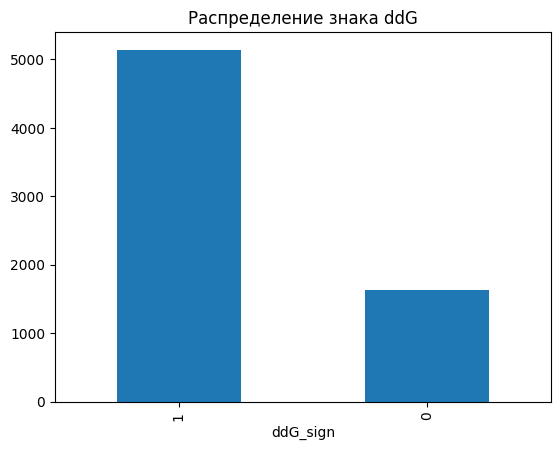

In [37]:
data_unique['ddG_sign'].value_counts().plot(kind='bar')
plt.title('Распределение знака ddG')
plt.show()

Судя по распределению нашей целевой переменной, модель будет лучше предсказывать положительные значения $\Delta \Delta G$. Т.е., можно ожидать баес.

In [38]:
data_unique.columns

Index(['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_proteins', 'Affinity_mut_parsed',
       'Affinity_wt_parsed', 'Protein 1', 'Protein 2', 'Temperature', 'Method',
       'dGmut', 'dGwt', 'ddG', 'ddG_sign'],
      dtype='object')

Все данные числового формата использовались для вычисления нашей response переменной. Обучать на них модель нельзя.

In [39]:
numeric_cols = ['Affinity_mut_parsed','Affinity_wt_parsed', 'Temperature',
               'dGmut', 'dGwt', 'ddG', 'ddG_sign']

Поэтому мы будем выбирать фичи для обучения из категориальных признаков:

In [40]:
cat_cols = ['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_proteins','Protein 1', 'Protein 2','Method']

In [41]:
data_unique[cat_cols][:100]

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_proteins,Protein 1,Protein 2,Method
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Subtilisin Carlsberg,Eglin c,IASP
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Subtilisin Carlsberg,Eglin c,IASP
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Subtilisin Carlsberg,Eglin c,IASP
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Subtilisin Carlsberg,Eglin c,IASP
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Subtilisin Carlsberg,Eglin c,IASP
...,...,...,...,...,...,...,...,...
97,1IAR_A_B,RA88Q,RA88Q,COR,1IAR_A_B,Interleukin-4,Interleukin-4 receptor,SPR
99,1IAR_A_B,RA88A,RA88A,COR,1IAR_A_B,Interleukin-4,Interleukin-4 receptor,SPR
100,1IAR_A_B,NA89A,NA89A,SUP,1IAR_A_B,Interleukin-4,Interleukin-4 receptor,SPR
102,1IAR_A_B,WA91A,WA91A,COR,1IAR_A_B,Interleukin-4,Interleukin-4 receptor,SPR


Из наших данных числовые фичи использовать для предсказания нелогично, так как через них мы получили предсказываемую фичу. Т.е., надо выбрать категориальные признаки для модели. Напрашивается использование модели, которая сразу принимает на вход категориальные данные, например, CatBoost, но попробуем сначала лог регрессию.<br>
Колонки метод (эксперимента), Pdb (ID белка в базе данных PDB), Protein 1 (название первой субединицы в комплексе), Protein 2 (название второй субъединицы в комплексе) и Hold_out_proteins (параметр для кросс-валидации при оценке эффективности моделей) в физическом смысле не влияют на конечный параметр. Поэтому тренировать модель мы будем на типе мутации (Mutation(s)_cleaned) и ее расположении (iMutation_location(s)).

In [56]:
features = [
    'Mutation(s)_cleaned',
    'iMutation_Location(s)'
    ]
cat_features = features
X = data_unique[features]
y = data_unique["ddG_sign"]
groups = data_unique["Hold_out_proteins"]

# оne-hot-кодирование категориальных признаков
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)

# делим на train/test (80/20)
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X_encoded, y, groups, test_size=0.2, random_state=42, stratify=y
)

# кросс-валидация с логистической регрессией
gkf = GroupKFold(n_splits=5)
cv_reports = []

for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = LogisticRegression(
        penalty='l2',
        C=1.0,          
        max_iter=1000,
        solver='lbfgs'
    )
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True)
    cv_reports.append(report)

# оценка среднего качества по кросс-валидации
avg_f1 = sum(r['1']['f1-score'] for r in cv_reports) / len(cv_reports)
print(f'Средний F1-score по классу 1: {avg_f1:.3f}')

# финальное обучение и оценка на тесте
final_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    max_iter=1000,
    solver='lbfgs'
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

print(classification_report(y_test, y_test_pred))

Средний F1-score по классу 1: 0.860
              precision    recall  f1-score   support

           0       0.71      0.09      0.16       327
           1       0.77      0.99      0.87      1028

    accuracy                           0.77      1355
   macro avg       0.74      0.54      0.51      1355
weighted avg       0.76      0.77      0.70      1355



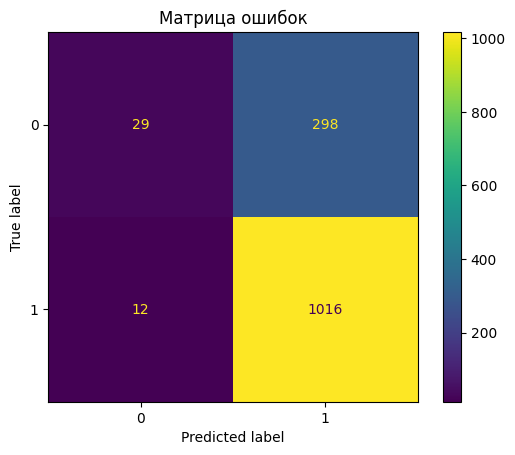

In [57]:
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title("Матрица ошибок")
plt.show()

На полученном выше матрице ошибок и соответствующих метриках мы можем заметить, что, как и ожидалось, модель лучше предсказывает положительные значения $\Delta \Delta G$, потому что изначально доля в трейне положительных значений, а значит доля единиц, была выше. 

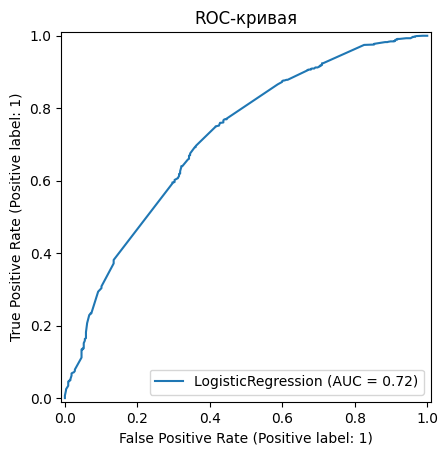

In [58]:
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.title("ROC-кривая")
plt.show()

На ROC-кривой мы видим, что площадь под кривой больше 0.5, значит, наша модель не случайно угадывает значения, но нуждается в улучшении.

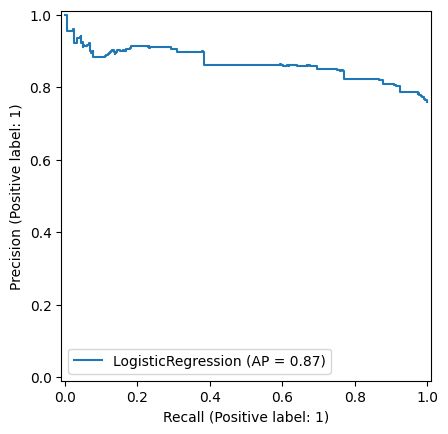

In [59]:
PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test)
plt.show()

На этом графике опять же мы можем увидеть, что класс 1 предсказывается хорошо, т.е. положительные значения $\Delta \Delta G$ предсказываются хорошо.

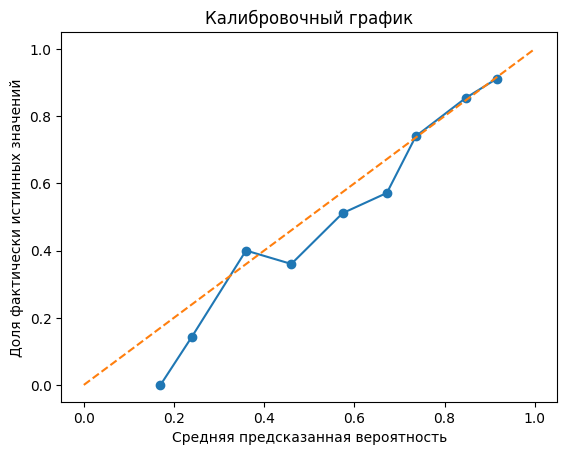

In [60]:
prob_pos = final_model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля фактически истинных значений')
plt.title('Калибровочный график')
plt.show()

Отклонение от идеальной калибровки в районе 0.2 - 0.4 скорее всего следствие дисбаланса в целевой переменной и малым количеством данных.

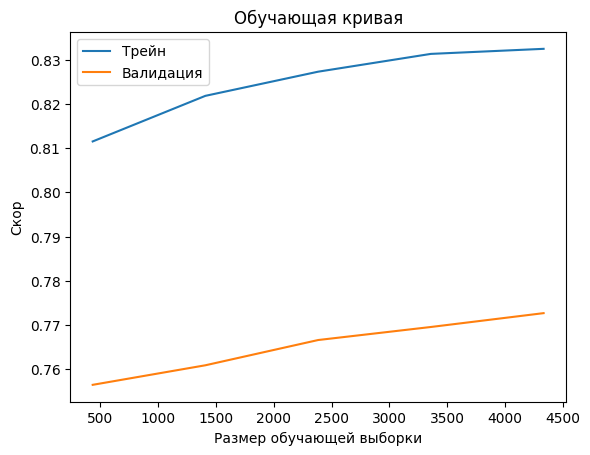

In [61]:
train_sizes, train_scores, test_scores = learning_curve(final_model, X_train, y_train, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Трейн')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Валидация')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Скор')
plt.legend()
plt.title('Обучающая кривая')
plt.show()

Большой разрыв в скоре между трейном и валидацией говорит о переобучении. Скорее всего, часть данных утекает из теста в трейн.

Попробуем catboost без групп, вдруг это сработает лучше

In [62]:
features = [
    'Mutation(s)_cleaned',
    'iMutation_Location(s)'
    ]
cat_features = features
X = data_unique[features]
y = data_unique["ddG_sign"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=4,
    l2_leaf_reg=10,
    subsample=0.8,
    cat_features=cat_features,
    early_stopping_rounds=50,
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Кросс-валидация
cv_scores = cross_val_score(
    model, X, y, cv=5, scoring='f1'
)
print(f'F1-score по кросс-валидации: {cv_scores.mean():.3f}')

0:	learn: 0.6823121	test: 0.6820716	best: 0.6820716 (0)	total: 276ms	remaining: 4m 36s
100:	learn: 0.4968673	test: 0.4928332	best: 0.4928332 (100)	total: 2.49s	remaining: 22.2s
200:	learn: 0.4919831	test: 0.4912581	best: 0.4912257 (186)	total: 4.24s	remaining: 16.8s
300:	learn: 0.4898897	test: 0.4913772	best: 0.4911589 (258)	total: 5.94s	remaining: 13.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4911589047
bestIteration = 258

Shrink model to first 259 iterations.
0:	learn: 0.6823092	total: 91.4ms	remaining: 1m 31s
100:	learn: 0.4967710	total: 1.8s	remaining: 16s
200:	learn: 0.4914316	total: 3.4s	remaining: 13.5s
300:	learn: 0.4893239	total: 5.89s	remaining: 13.7s
400:	learn: 0.4879841	total: 7.48s	remaining: 11.2s
500:	learn: 0.4867784	total: 9.1s	remaining: 9.06s
600:	learn: 0.4854111	total: 10.8s	remaining: 7.14s
700:	learn: 0.4839863	total: 12.4s	remaining: 5.27s
800:	learn: 0.4825492	total: 14.1s	remaining: 3.49s
900:	learn: 0.4814562	total: 18.2s	remaini

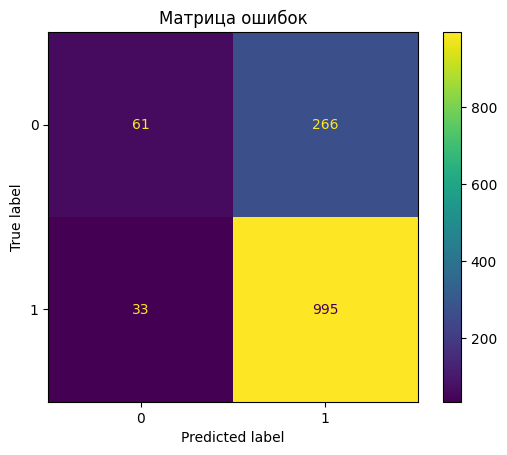

In [63]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Матрица ошибок")
plt.show()

In [64]:
test_preds = model.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.65      0.19      0.29       327
           1       0.79      0.97      0.87      1028

    accuracy                           0.78      1355
   macro avg       0.72      0.58      0.58      1355
weighted avg       0.76      0.78      0.73      1355



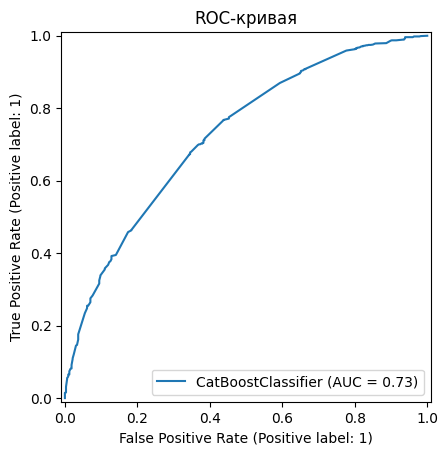

In [65]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC-кривая")
plt.show()

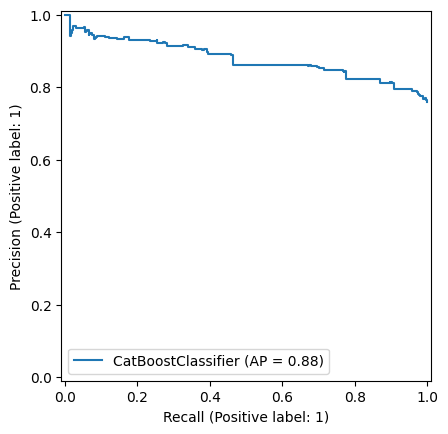

In [66]:
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.show()

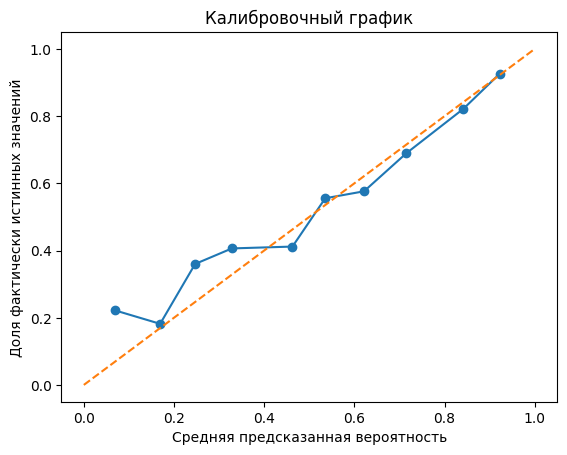

In [67]:
prob_pos = model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля фактически истинных значений')
plt.title('Калибровочный график')
plt.show()

0:	learn: 0.6825725	total: 46.4ms	remaining: 46.4s
100:	learn: 0.4968365	total: 269ms	remaining: 2.39s
200:	learn: 0.4865428	total: 428ms	remaining: 1.7s
300:	learn: 0.4728341	total: 598ms	remaining: 1.39s
400:	learn: 0.4642798	total: 747ms	remaining: 1.12s
500:	learn: 0.4576927	total: 963ms	remaining: 959ms
600:	learn: 0.4510090	total: 1.14s	remaining: 756ms
700:	learn: 0.4459190	total: 1.3s	remaining: 553ms
800:	learn: 0.4417065	total: 1.47s	remaining: 365ms
900:	learn: 0.4375029	total: 1.64s	remaining: 181ms
999:	learn: 0.4334596	total: 1.82s	remaining: 0us
0:	learn: 0.6816351	total: 22.3ms	remaining: 22.3s
100:	learn: 0.5040545	total: 421ms	remaining: 3.75s
200:	learn: 0.4963946	total: 629ms	remaining: 2.5s
300:	learn: 0.4915639	total: 880ms	remaining: 2.04s
400:	learn: 0.4878310	total: 1.11s	remaining: 1.66s
500:	learn: 0.4848958	total: 1.46s	remaining: 1.45s
600:	learn: 0.4822121	total: 1.65s	remaining: 1.1s
700:	learn: 0.4800954	total: 1.88s	remaining: 802ms
800:	learn: 0.477625

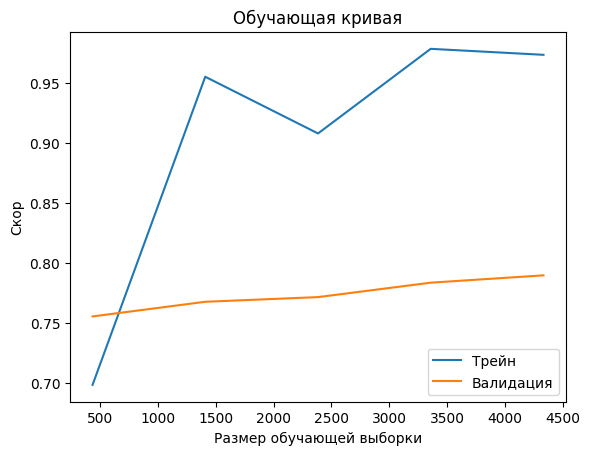

In [68]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Трейн')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Валидация')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Скор')
plt.legend()
plt.title('Обучающая кривая')
plt.show()

Catboost не улучшил ситуацию. Точность немного выше, приэтом переобучение больше выражено на последнем графике. Можно подумать или об утечке теста в трейн, или о малом датасете.

Спасибо за прочтение!